### Here is our notebook to make a style transfer for cartoon images.

The only thing you have to do is to launch each section one after the other, making sure that the notebook is running on GPU. In the ***Inputs*** section you will have to give a style image and a content image and you can change some parameters

**Marius JENIN
Alexandre LANVIN**

# Initialization

## Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Create Environment

In [ ]:
import sys
PATH_OF_DATA= '/content/gdrive/"My Drive"/cartoonizer_data'
sys.path.append(PATH_OF_DATA)
%mkdir $PATH_OF_DATA &> /dev/null
%cd $PATH_OF_DATA
!rm ./* &> /dev/null

/content/gdrive/My Drive/cartoonizer_data


## Imports

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

## Inputs

### Variables

In [ ]:
size_output_image = 512
minimum_iteration = 4000
loss_spike_bias = 0.5
# Good results with 100000 and 1
style_weight = 100000
content_weight = 1

### Content Style Input

Loader for inputs image

In [ ]:
loader = transforms.Compose([ transforms.Resize(size_output_image), transforms.ToTensor()])


def image_loader(uploaded,image_name):
    image = Image.open(BytesIO(uploaded[image_name]))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

Content Input

In [ ]:
uploaded = files.upload()
content_img_open = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

Saving city.jpg to city.jpg


Style Input

In [ ]:
uploaded = files.upload()
style_img_open = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

Saving anime_city.jpg to anime_city.jpg


Resize and load

In [ ]:
w,h = content_img_open.size
style_img_open = style_img_open.resize((w,h))

image = loader(style_img_open).unsqueeze(0)
style_img = image.to(device, torch.float)
image = loader(content_img_open).unsqueeze(0)
content_img = image.to(device, torch.float)

Plot the input images

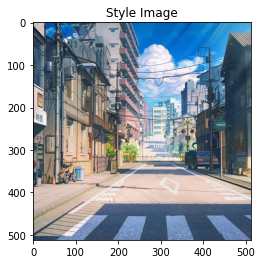

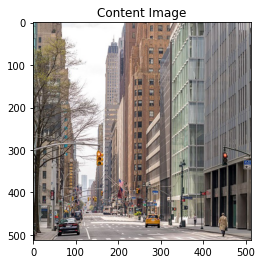

In [ ]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Model Definition

Content Loss

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Style Loss

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Normalization

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Model Creation

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Optimizer : LBFGS

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

# Run the Style Transfer

Definition of the run function

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, 
                       style_weight, content_weight, num_steps, bias):
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    style_minimum = [1000000000000]
    content_minimum = [1000000000000]

    bias = [bias]

    steps = [num_steps]
    run = [0]
    while run[0] <= steps[0]:

        def closure():
            run[0] += 1
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # if run[0] % 50 == 0:
                # print("run {}:".format(run))
                # print('Style Loss : {} Content Loss: {}'.format(style_score.item(), content_score.item()))


            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                # print()

            if run[0] >= steps[0] and style_score >= style_minimum[0]+bias[0] and content_score >= content_minimum[0]+bias[0] :
                steps[0]+=1

            if style_score < style_minimum[0]:
                style_minimum[0] = style_score

            if content_score < content_minimum[0]:
                content_minimum[0] = content_score
                
            return style_score + content_score
        optimizer.step(closure)
      

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Execute

run [50]:
Style Loss : 38.095871 Content Loss: 38.516083
run [100]:
Style Loss : 9.746272 Content Loss: 23.728615
run [150]:
Style Loss : 5.597669 Content Loss: 15.768721
run [200]:
Style Loss : 3.861484 Content Loss: 11.343042
run [250]:
Style Loss : 2.836910 Content Loss: 8.989590
run [300]:
Style Loss : 2.169913 Content Loss: 7.770462
run [350]:
Style Loss : 1.730319 Content Loss: 7.118214
run [400]:
Style Loss : 1.403826 Content Loss: 6.810844
run [450]:
Style Loss : 1.180892 Content Loss: 6.578357
run [500]:
Style Loss : 1.060754 Content Loss: 6.450040
run [550]:
Style Loss : 1.037091 Content Loss: 6.372819
run [600]:
Style Loss : 1.034800 Content Loss: 6.302854
run [650]:
Style Loss : 1.058241 Content Loss: 6.450915
run [700]:
Style Loss : 64.186150 Content Loss: 10.057943
run [750]:
Style Loss : 0.929967 Content Loss: 5.772035
run [800]:
Style Loss : 0.997041 Content Loss: 6.095836
run [850]:
Style Loss : 2.163942 Content Loss: 6.331771
run [900]:
Style Loss : 0.966741 Content L

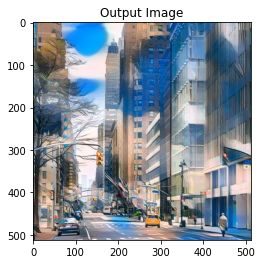

In [ ]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, style_weight, content_weight, minimum_iteration, loss_spike_bias)
save_image(output,"output.jpg")

plt.figure()
imshow(output, title='Output Image')